Сделаем все необходимые установки и импорты:

In [ ]:
!pip install torchmetrics torch-fidelity
!pip install wandb
!pip install -q kaggle

import os
from google.colab import files
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from torch import optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchmetrics.image.fid import FrechetInceptionDistance
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


Загрузим архив картинок напрямую с [kaggle](https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset/data) и распакуем его:

In [ ]:
files.upload() # необходимо подгрузить kaggle.json своего аккаунта
!chmod 600 /content/kaggle.json

!rm -r /root/.kaggle
!mkdir /root/.kaggle
!mv /content/kaggle.json /root/.kaggle/

!kaggle datasets download -d hlrhegemony/pokemon-image-dataset

zip_ref = zipfile.ZipFile('pokemon-image-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 85% 49.0M/57.9M [00:00<00:00, 110MB/s]
100% 57.9M/57.9M [00:00<00:00, 111MB/s]


Залогинимся в wandb, чтобы трекать с его помощью статистику при обучении:

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Загрузка данных

In [ ]:
data_dir = '/content/images'

img_size = 128
mean_pic = [0.485, 0.456, 0.406]
std_pic = [0.229, 0.224, 0.225]

batch_size = 128

In [ ]:
transformer = transforms.Compose([transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean_pic, std_pic)])
dataset = ImageFolder(root=data_dir, transform=transformer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# при обучение будем использовать последний батч как тестовый для оценки метрики; сохраним отдельно его размер
val_batch_size = len(dataset) - (len(dataloader) - 1)*batch_size

Ради интереса визуализируем один батч реальных картинок:  

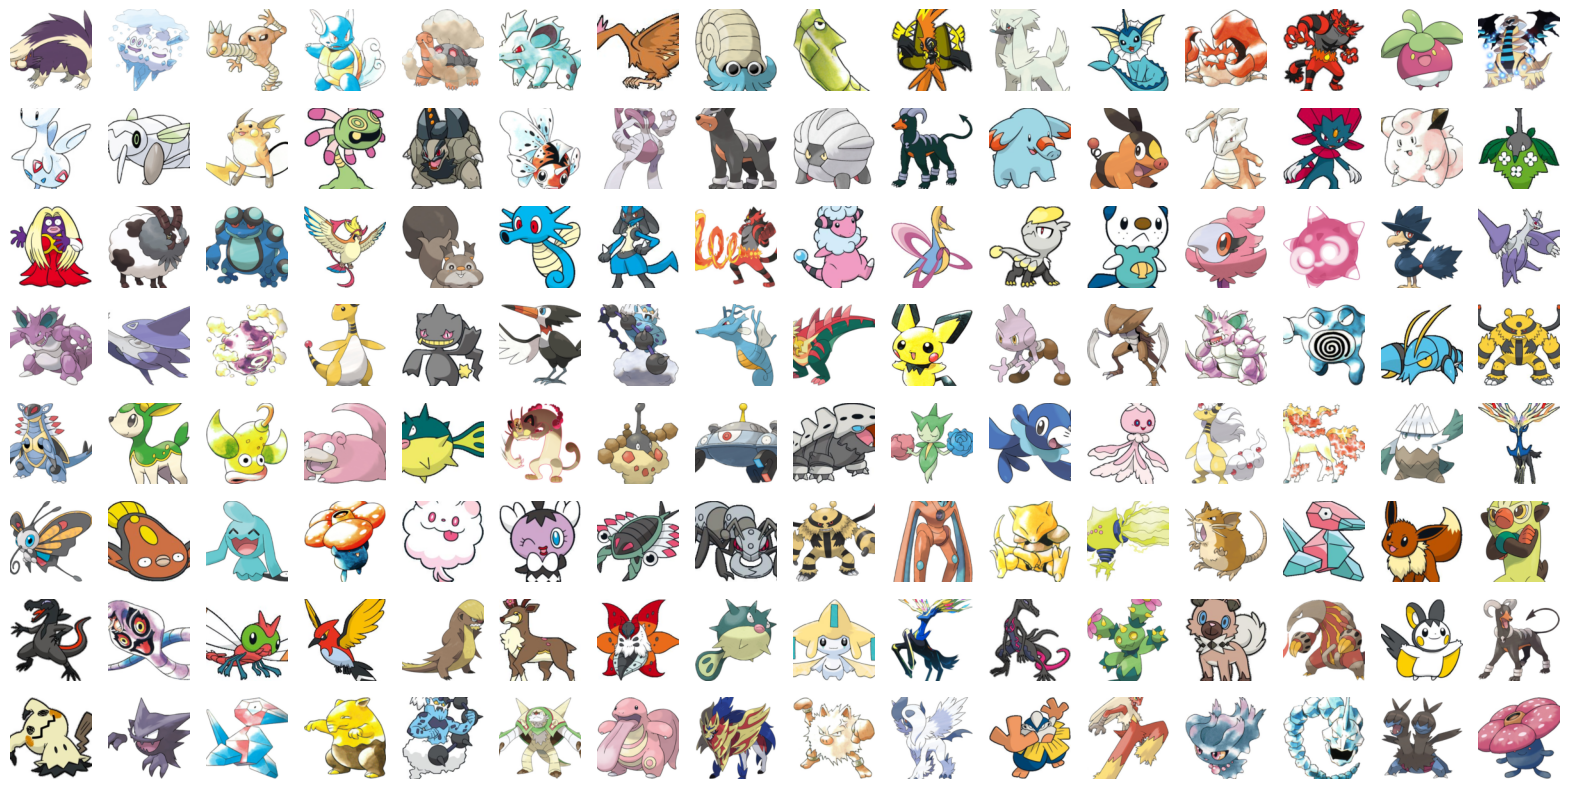

In [ ]:
real_batch = next(iter(dataloader))
images, _ = real_batch
fig, axes = plt.subplots(8, 16, figsize=(20, 10))
for i, ax in enumerate(axes.reshape(-1)):
    ax.axis(False)
    img = images[i]
    # для визуализации откатим нормировку
    for j in range(3):
        img[j] = img[j] * std_pic[j] + mean_pic[j]

    ax.imshow(img.permute(1, 2, 0))

# Описание модели и код тренировки

Я решил воспользоваться моделью [DCGAN](https://arxiv.org/abs/1511.06434). Значения всех параметров и гиперпараметров соответствуют значениям, описанным в оригинальной статье. При обучении также использованы некоторые лайфхаки [отсюда](https://github.com/soumith/ganhacks).

In [ ]:
class Generator(nn.Module):
    def __init__(self, lat_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(lat_size, 1024, 8, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # Conv1
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # Conv2
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Conv3
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Conv4
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh())

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # входной слой
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # слой 1
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # слой 2
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # слой 4
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # слой 5
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # выходной слой
            nn.Conv2d(1024, 1, 4, 1, bias=False),
            nn.Sigmoid())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [ ]:
class DCGAN(object):
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.criterion = nn.BCELoss()
        self.real_label = 1
        self.fake_label = 0
        self.fid = FrechetInceptionDistance(feature=64, normalize=True)
        self.fid.to(self.device)
        self.best_fid = 1e+6
        self.best_epoch = 0


    def base_model_init(self, lat_size, lr, beta1, beta2, mean_conv, std_conv, mean_bn, std_bn):
        self.lat_size = lat_size
        self.gen = Generator(self.lat_size).to(self.device)
        for m in self.gen._modules:
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, mean_conv, std_conv)
            elif classname.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, mean_bn, std_bn)
                nn.init.constant_(m.bias.data, 0)
        self.gen_optim = optim.Adam(self.gen.parameters(), lr=lr, betas=(beta1, beta2))

        self.dis = Discriminator().to(self.device)
        for m in self.dis._modules:
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, mean_conv, std_conv)
            elif classname.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, mean_bn, std_bn)
                nn.init.constant_(m.bias.data, 0)
        self.dis_optim = optim.Adam(self.dis.parameters(), lr=lr, betas=(beta1, beta2))

    def pretrained_model_init(self, path_to_gen_model, path_to_dis_model, lat_size, lr, beta1, beta2):
        self.lat_size = lat_size
        self.gen = Generator(self.lat_size).to(self.device)
        self.gen.load_state_dict(torch.load(path_to_gen_model))
        self.gen_optim = optim.Adam(self.gen.parameters(), lr=lr, betas=(beta1, beta2))

        self.dis = Discriminator().to(self.device)
        self.dis.load_state_dict(torch.load(path_to_dis_model))
        self.dis_optim = optim.Adam(self.dis.parameters(), lr=lr, betas=(beta1, beta2))

    def train(self, num_epochs, dataloader, val_batch_size, wandb_tracking=True):
        # будем использовать этот шум для измерения текущего качества
        self.const_noise = torch.randn(val_batch_size, self.lat_size, 1, 1, device=self.device)
        print('\nОбучение запущено\n')
        if wandb_tracking:
            wandb.init(project='test_IMS', name='DCGAN_training')
        for epoch in range(num_epochs):
            gen_losses = []
            dis_losses = []
            for i, (batch, _) in enumerate(dataloader):
                batch = batch.to(self.device)
                if (i != len(dataloader)-1):
                # шаг обучения дискриминатора
                    self.dis.zero_grad()
                    # батч реальных картинок
                    output = self.dis(batch).view(-1)
                    labels = torch.full((batch.size(0),), self.real_label, dtype=torch.float, device=self.device)
                    real_D_err = self.criterion(output, labels)
                    real_D_err.backward()

                    # батч фэйковых картинок
                    noise = torch.randn(batch.size(0), self.lat_size, 1, 1, device=device)
                    fakes = self.gen(noise)
                    labels.fill_(self.fake_label)
                    output = self.dis(fakes.detach()).view(-1)
                    fake_D_err = self.criterion(output, labels)
                    fake_D_err.backward()

                    D_err = real_D_err + fake_D_err
                    dis_losses.append(D_err.item())
                    self.dis_optim.step()

                # шаг обучения генератора
                    self.gen.zero_grad()
                    labels.fill_(self.real_label)
                    output = self.dis(fakes).view(-1)
                    G_err = self.criterion(output, labels)
                    gen_losses.append(G_err.item())
                    G_err.backward()
                    self.gen_optim.step()
                else:
                # измеряем текущее качество, трекаем метрику и всякую статистику
                    fakes = self.gen(self.const_noise)
                    self.fid.update(batch, real=True)
                    self.fid.update(fakes, real=False)
                    metric = self.fid.compute()
                    self.fid.reset()

                    if (metric < self.best_fid):
                        self.best_fid = metric
                        self.best_epoch = epoch
                        torch.save(self.gen.state_dict(), 'dcgan_gen.pt')
                        torch.save(self.dis.state_dict(), 'dcgan_dis.pt')

                    if wandb_tracking:
                        images = wandb.Image(fakes)
                        wandb.log({'epoch': epoch,
                               'mean gen_loss per epoch': np.mean(gen_losses),
                               'mean dis_loss per epoch': np.mean(dis_losses),
                               'FID': metric.item(), 'examples': images})
                        if (epoch == np.ceil(num_epochs / 2) - 1):
                            print('\nПоловина эпох пройдена!')
                    else:
                        print(f'epoch  №{epoch} done!\tFID={metric:.3f}')

        if wandb_tracking:
            print(f'\nОбучение закончено. Лучшее качество (FID={self.best_fid:.3f}) достигнуто на {self.best_epoch} эпохе.')
            wandb.finish()

    def eval(self, input, visualize=True) -> torch.Tensor:
        result = self.gen(input.to(self.device))
        if visualize:
            sqrt_size = np.sqrt(input.size(0))
            if sqrt_size.is_integer():
                plt.figure(figsize=(sqrt_size*4, sqrt_size*4))
                plt.axis('off')
                plt.title('Generated pokemon', fontsize=20)
                plt.imshow(np.transpose(vutils.make_grid(result.cpu(), normalize=True, nrow=int(sqrt_size)), (1,2,0)))
                plt.show()
            else:
                nrows = np.ceil(sqrt_size)
                plt.figure(figsize=(nrows*4, np.ceil(input.size(0) / nrows)*4))
                plt.axis('off')
                plt.title('Generated pokemon', fontsize=20)
                plt.imshow(np.transpose(vutils.make_grid(result.cpu(), normalize=True, nrow=int(nrows)), (1,2,0)))
                plt.show()

        return result

# Обучение

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lat_size = 100
lr = 2e-4
beta1 = 0.5
beta2 = 0.999
mean_conv = 0
std_conv = 0.02
mean_bn = 1
std_bn = 0.02

num_epochs = 50

In [ ]:
dcgan = DCGAN(device)
dcgan.base_model_init(lat_size, lr, beta1, beta2, mean_conv, std_conv, mean_bn, std_bn)
dcgan.train(num_epochs, dataloader, val_batch_size, wandb_tracking=True)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 323MB/s]
wandb: Currently logged in as: ednovosiltsev (nov_team). Use `wandb login --relogin` to force relogin



Обучение запущено




Половина эпох пройдена!

Обучение закончено. Лучшее качество (FID=7.661) достигнуто на 48 эпохе.


# Работа с уже обученной моделью

Создадим новый экземпляр класса DCGAN, проинициализируем его весами лучшей модели, полученной при обучении, и применим для генерации нескольких новых изображений покемонов:

In [ ]:
dcgan = DCGAN(device)
dcgan.pretrained_model_init('/content/dcgan_gen.pt', '/content/dcgan_dis.pt', lat_size, lr, beta1, beta2)

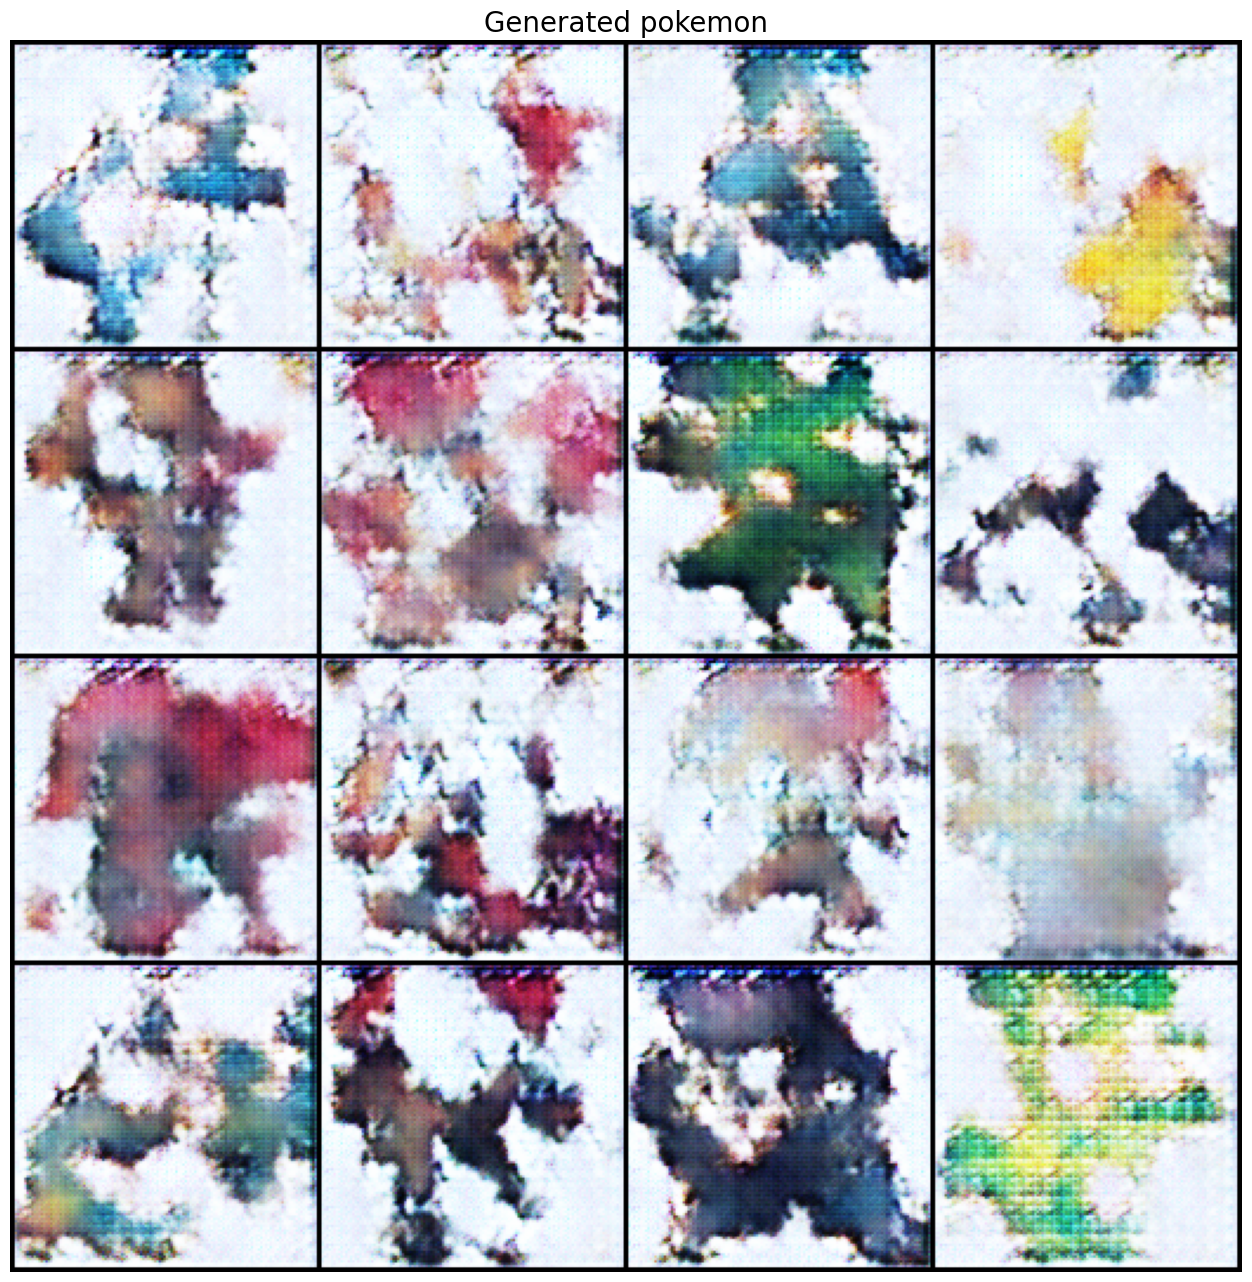

In [ ]:
input = torch.randn(16, lat_size, 1, 1)
output = dcgan.eval(input)